# Recommender Systems

这一部分，我们将实现协同过滤学习算法，并将其应用于电影评分的数据集，评分由1-5个等级组成，用户未评级的用0代替<br/>
数据集有nu=943个用户和nm=1682部电影

In [137]:
#输出多个output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [138]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

### 数据初始化

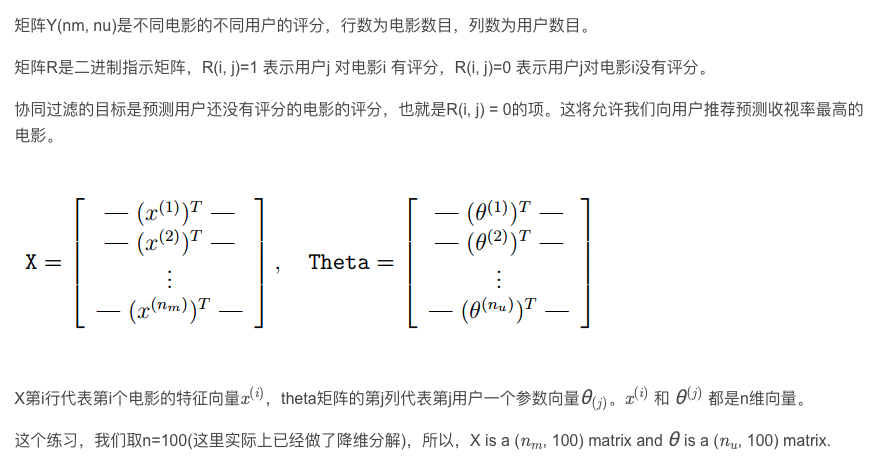

In [139]:
data = loadmat("movies.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [140]:
Y,R = data["Y"],data["R"]
type(Y),type(R)
Y.shape,R.shape

(numpy.ndarray, numpy.ndarray)

((1682, 943), (1682, 943))

### Randomly Initialize Function

In [141]:
#范围为-0.3～0.3,一共生成row*col个元素
def random_initial(row,col):
    return np.array(np.random.uniform(-0.3,0.3,row*col)).reshape(row,col)

### Mean Normalization

In [142]:
#注意只对有评分的数据求均值，没有评分的数据不包含在内，要用R矩阵判断。
def meanNormalize(Y,R):
    Ymean = (Y.sum(axis=1)/R.sum(axis=1)).reshape(-1,1)#未评分的电影评级用0代替
    Ynorm = (Y-Ymean)*R #不要归一化未评分的数据
    return Ynorm,Ymean

### Parameters Serialize

为了使用高级优化算法，我们将X和theta展成一维数组，跟神经网络思路一样

In [143]:
def serialize(X,Theta):
    return np.r_[X.ravel(),Theta.ravel()]

In [144]:
def deserialize(seq,nm,nu,n):
    return seq[:nm*n].reshape(nm,n),seq[nm*n:].reshape(nu,n)

### Regularization Cost Function

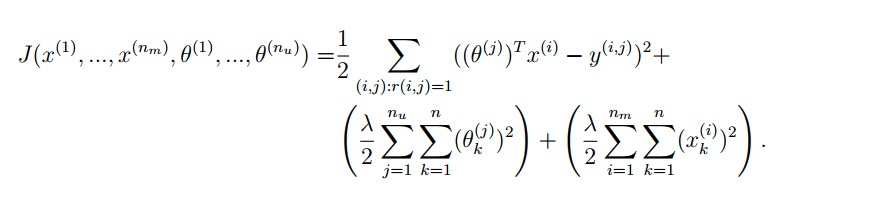

In [145]:
def costFunction(params,Y,R,nm,nu,n,l):
    """
    params : 拉成一维之后的参数向量(X, Theta)
    Y : 评分矩阵 (nm, nu)
    R ：0-1矩阵，表示用户对某一电影有无评分
    nu : 用户数量
    nm : 电影数量
    nf : 自定义的特征的维度
    l : lambda for regularization
    """
    X, Theta = deserialize(params,nm,nu,n)
    Error = 0.5*np.sum(np.power(((X@Theta.T-Y)*R),2)) # *代表array对应项相乘
    reg1 = (l/2)*np.sum(np.power(Theta,2))
    reg2 = (l/2)*np.sum(np.power(X,2))
    return Error+reg1+reg2

### Collaborative Filtering Gradient

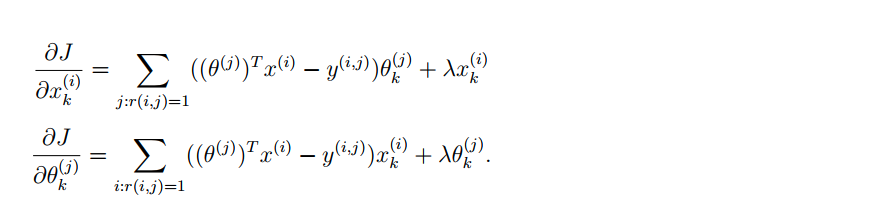

In [146]:
def cofiGradient(params,Y,R,nm,nu,n,l):
    X, Theta = deserialize(params,nm,nu,n)
    X_grad = ((X@Theta.T-Y)*R)@Theta + l*X
    Theta_grad = ((X@Theta.T-Y)*R).T@X + l*Theta
    return serialize(X_grad,Theta_grad)

### Gradient Checking

In [147]:
def gradient_checking(params,Y,R,nm,nu,n,e):
    def a_numeric_grad(plus,minus):
        return (costFunction(plus,Y,R,nm,nu,n,0)-costFunction(minus,Y,R,nm,nu,n,0))/(2*e) #取lamda=1
    numeric_grad = []
    for i in range(len(params)):
        plus = params.copy()
        minus = params.copy()
        plus[i] = plus[i] + e
        minus[i] = minus[i] - e
        numeric_grad_i = a_numeric_grad(plus,minus)
        numeric_grad.append(numeric_grad_i)
    numeric_grad = np.array(numeric_grad)
    Delta_grad = cofiGradient(params,Y,R,nm,nu,n,0)
    diff = np.linalg.norm(numeric_grad-Delta_grad)/np.linalg.norm(numeric_grad+Delta_grad)#np.linalg.norm求范数
    print(''''If your backpropagation implementation is correct,\n
          the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
          \nRelative Difference: {}\n'''.format(diff))

当数据量很大的时候，gradient checking函数运行很慢，所以我们取出一部分，来运算：<br/>
movieParams.mat文件提供了一些参数

In [148]:
mat = loadmat('movieParams.mat')
X = mat['X']
Theta = mat['Theta']
nu = int(mat['num_users'])
nm = int(mat['num_movies'])
nf = int(mat['num_features'])
# For now, reduce the data set size so that this runs faster
nu = 4; nm = 5; nf = 3
X = X[:nm,:nf]
Theta = Theta[:nu,:nf]
Y = Y[:nm,:nu]
R = R[:nm,:nu]

In [149]:
params = serialize(X,Theta)

In [150]:
gradient_checking(params,Y,R,nm,nu,nf,0.0001)

'If your backpropagation implementation is correct,

          the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
          
Relative Difference: 8.947000508723921e-13



Nice work！

### Learning Movie Recommendations

我们将添加一个新的用户对电影的评价（其中很多电影未评价）。然后训练协同过滤模型，输出预测的新用户的对未评级电影的评级。

In [151]:
#获取所有电影的列表
movies = []  
movie_data = open('movie_ids.txt','r', encoding='latin-1') 
for line in movie_data.readlines():
    movie_i = " ".join(line.strip().split(" ")[1:])#用空格合并list里的字符串
    movies.append(movie_i)
len(movies)

1682

In [152]:
movies

['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Twelve Monkeys (1995)',
 'Babe (1995)',
 'Dead Man Walking (1995)',
 'Richard III (1995)',
 'Seven (Se7en) (1995)',
 'Usual Suspects, The (1995)',
 'Mighty Aphrodite (1995)',
 'Postino, Il (1994)',
 "Mr. Holland's Opus (1995)",
 'French Twist (Gazon maudit) (1995)',
 'From Dusk Till Dawn (1996)',
 'White Balloon, The (1995)',
 "Antonia's Line (1995)",
 'Angels and Insects (1995)',
 'Muppet Treasure Island (1996)',
 'Braveheart (1995)',
 'Taxi Driver (1976)',
 'Rumble in the Bronx (1995)',
 'Birdcage, The (1996)',
 'Brothers McMullen, The (1995)',
 'Bad Boys (1995)',
 'Apollo 13 (1995)',
 'Batman Forever (1995)',
 'Belle de jour (1967)',
 'Crimson Tide (1995)',
 'Crumb (1994)',
 'Desperado (1995)',
 'Doom Generation, The (1995)',
 'Free Willy 2: The Adventure Home (1995)',
 'Mad Love (1995)',
 'Nadja (1994)',
 'Net, The (1995

In [153]:
#假设的新用户评价,未评分的电影评级用0代替
my_ratings = np.zeros((1682,1))

my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {} for movie {}'.format(*my_ratings[i].astype("int"),movies[i]))

Rated 4 for movie Toy Story (1995)
Rated 3 for movie Twelve Monkeys (1995)
Rated 5 for movie Usual Suspects, The (1995)
Rated 4 for movie Outbreak (1995)
Rated 5 for movie Shawshank Redemption, The (1994)
Rated 3 for movie While You Were Sleeping (1995)
Rated 5 for movie Forrest Gump (1994)
Rated 2 for movie Silence of the Lambs, The (1991)
Rated 4 for movie Alien (1979)
Rated 5 for movie Die Hard 2 (1990)
Rated 5 for movie Sphere (1998)


In [154]:
#导入Y和R矩阵
data = loadmat("movies.mat")
Y,R = data["Y"],data["R"]
type(Y),type(R)
Y.shape,R.shape

(numpy.ndarray, numpy.ndarray)

((1682, 943), (1682, 943))

In [155]:
#将新用户数据添加到矩阵中
Y = np.c_[Y,my_ratings]
R_new = (my_ratings!=0).astype("int")
R = np.c_[R,R_new]
Y.shape,R.shape

((1682, 944), (1682, 944))

In [156]:
nm,nu = Y.shape
n = 10 #这里我们选择使用10维的特征向量

In [157]:
Ynorm,Ymean = meanNormalize(Y,R)
Ynorm.shape,Ymean.shape

((1682, 944), (1682, 1))

In [158]:
#随机初始化参数
X = random_initial(nm,n)
Theta = random_initial(nu,n)

In [159]:
#fit the model
params = serialize(X,Theta)
import scipy.optimize as opt
res = opt.minimize(fun=costFunction,x0=params,args=(Ynorm,R,nm,nu,n,10),method="TNC",jac=cofiGradient,
                     options={"maxiter":100})
result = res["x"]

In [160]:
fit_X,fit_Theta = deserialize(result,nm,nu,n)
fit_X.shape,fit_Theta.shape

((1682, 10), (944, 10))

In [161]:
#Make recommendations
Pred_movie = fit_X @ fit_Theta.T
new_pred = Pred_movie[:,-1] + Ymean.ravel()

In [162]:
pred_sort_index = np.argsort(-new_pred)#获取评分从大到小排列对应的下标
print("Top recommendations for you:")
for i in range(30):
    print('Predicting rating {:.0f} for movie {}'.format(new_pred[pred_sort_index[i]],movies[pred_sort_index[i]]))

Top recommendations for you:
Predicting rating 5 for movie Aiqing wansui (1994)
Predicting rating 5 for movie Prefontaine (1997)
Predicting rating 5 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5 for movie Someone Else's America (1995)
Predicting rating 5 for movie Great Day in Harlem, A (1994)
Predicting rating 5 for movie Santa with Muscles (1996)
Predicting rating 5 for movie Star Kid (1997)
Predicting rating 5 for movie They Made Me a Criminal (1939)
Predicting rating 5 for movie Saint of Fort Washington, The (1993)
Predicting rating 5 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5 for movie Pather Panchali (1955)
Predicting rating 5 for movie Star Wars (1977)
Predicting rating 5 for movie Shawshank Redemption, The (1994)
Predicting rating 5 for movie Maya Lin: A Strong Clear Vision (1994)
Predicting rating 5 for movie Anna (1996)
Predicting rating 5 for movie Schindler's List (1993)
Predicting rating 5 for movie Some Mother